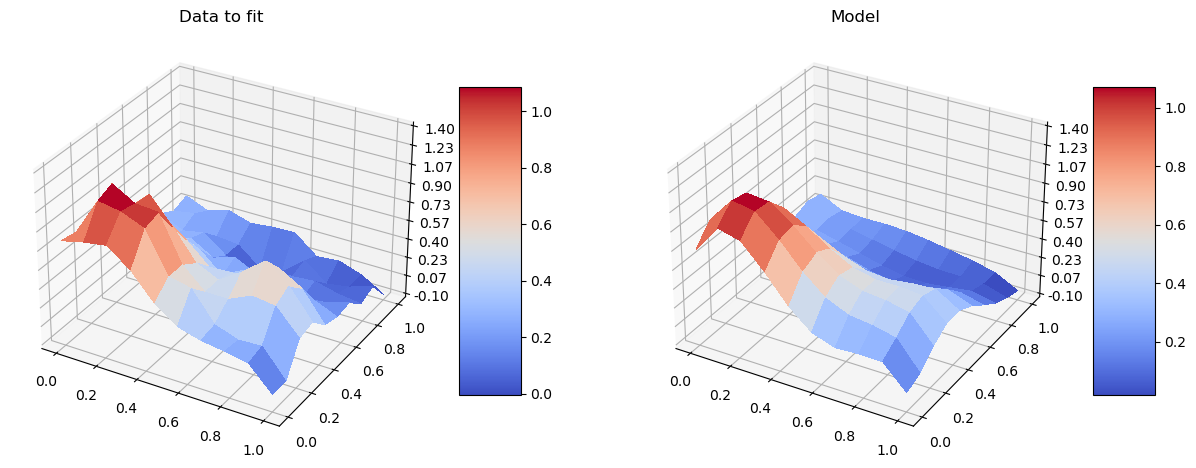

In [5]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed



class MyStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.var_ = None

    def fit(self, X):
        p = X.shape[1]
        self.mean_ = np.zeros(p)
        self.var_ = np.zeros(p)
        for i in range(p):
            self.mean_[i] = np.mean(X[:, i])
            self.var_[i] = np.var(X[:, i])

    def transform(self, X, with_std=True, with_mean=True):
        if self.mean_ is None or self.var_ is None:
            raise ValueError("Call fit first")

        if with_mean:
            X = X - self.mean_.reshape(1, -1)
        if with_std:
            X /= np.sqrt(self.var_).reshape(1, -1)
        return X

    def fit_transform(self, X, with_std=True, with_mean=True):
        self.fit(X)
        return self.transform(X, with_std, with_mean)





def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n


def R2(y_data,y_model):
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data-np.mean(y_model))**2)


def fit_beta(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y


def fit_beta_ridge(X, y, l):
    p = X.shape[1]
    return np.linalg.inv(X.T @ X + (l * np.eye(p))) @ X.T @ y


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4



n = 10
degree = 5
Lambda = 1
np.random.seed()





x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
xx , yy = np.meshgrid(x,y)
z = FrankeFunction(xx, yy) + 0.06 *np.random.randn(n,n)
# Make data set.


fig = plt.figure(figsize=(15,8))
fig.tight_layout()
ax = fig.add_subplot(1,2,1,projection='3d')
ax.title.set_text("Data to fit")
# Plot the surface.
surf = ax.plot_surface(xx, yy, z, cmap=cm.coolwarm, # type: ignore
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)










X = np.concatenate((xx.ravel(), yy.ravel())).reshape(2,-1).T

scaler = StandardScaler()       # sklearn scaler
myScaler = MyStandardScaler()   # own implementation of standard scaler
poly = PolynomialFeatures(degree,include_bias=True)


# fit polynomial and scale
x_train, x_test, y_train, y_test = train_test_split(X, z.ravel(), test_size=0.2)
X_train = poly.fit_transform(x_train)
X_test = poly.transform(x_test)
X_train_scaled = scaler.fit_transform(X_train[:,1:])
X_test_scaled = scaler.transform(X_test[:,1:])
y_train_mean = np.mean(y_train)
y_train_scaled = y_train - y_train_mean


# fit beta
beta_scaled = fit_beta(X_train_scaled,y_train_scaled)
beta = fit_beta(X_train, y_train)
beta_ridge = fit_beta_ridge(X_train, y_train, Lambda)
beta_ridge_scaled = fit_beta_ridge(X_train_scaled, y_train_scaled, Lambda)

predict = (scaler.transform(poly.transform(X)[:,1:]) @ beta_scaled) + y_train_mean 
predict2d = predict.reshape(n,n)
ytilde_scaled = X_test_scaled @ beta_scaled + y_train_mean
ytilde = X_test @ beta
ytilde_scaled_ridge = X_test_scaled @ beta_ridge_scaled + y_train_mean
ytilde_rigde = X_test @ beta_ridge




# ax = fig.gca(projection='3d')
ax = fig.add_subplot(1,2,2,projection='3d')
ax.title.set_text("Model")

surf = ax.plot_surface(xx, yy, predict2d, cmap=cm.coolwarm, # type: ignore
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Discussion on scaling data

In [6]:
np.set_printoptions(precision=4, suppress=True)

print(X_train)
print(X_train_scaled)
print(beta)
print(beta_scaled)
print(beta_ridge_scaled)
print(beta_ridge)


print(MSE(y_test,ytilde ))
print(MSE(y_test,ytilde_scaled ))
print(MSE(y_test,ytilde_rigde))
print(MSE(y_test,ytilde_scaled_ridge))



[[1.     0.4444 0.1111 ... 0.0003 0.0001 0.    ]
 [1.     0.1111 0.6667 ... 0.0037 0.0219 0.1317]
 [1.     0.6667 0.     ... 0.     0.     0.    ]
 ...
 [1.     0.5556 0.7778 ... 0.1452 0.2033 0.2846]
 [1.     0.1111 0.3333 ... 0.0005 0.0014 0.0041]
 [1.     0.1111 1.     ... 0.0123 0.1111 1.    ]]
[[-0.1589 -1.186  -0.4441 ... -0.5323 -0.5739 -0.6445]
 [-1.218   0.5266 -1.0075 ... -0.5151 -0.4738 -0.2395]
 [ 0.5472 -1.5285  0.307  ... -0.5337 -0.5742 -0.6446]
 ...
 [ 0.1942  0.8691 -0.1061 ...  0.2034  0.3563  0.231 ]
 [-1.218  -0.5009 -1.0075 ... -0.5314 -0.568  -0.6319]
 [-1.218   1.5542 -1.0075 ... -0.471  -0.0657  2.4319]]
[  0.7229   3.9767   2.1438 -18.0528  -4.17    -6.4237  18.121   22.2539
   2.8984  -4.8105   2.11   -36.8529  14.0813 -16.4034  19.5616  -6.8359
  16.242    0.3254 -10.1872  12.1239 -10.8696]
[ 1.2515  0.6954 -5.934  -1.0713 -2.1687  5.8813  5.2752  0.6909 -1.6097
  0.6718 -8.2806  2.976  -3.717   6.4458 -2.1399  3.5101  0.064  -2.007
  2.6489 -3.5332]
[-0.1377

First unscaled $X_{\text{unscaled}}$ and scaled $X_{\text{scaled}}$ is not that different, the original data was close to zero-centerd and not that spread out, which means that initaially by just looking at the data scaling is not that nececary. When we add the polynomial terms we can now see that some of the entries of $X_{\text{unscaled}}$ get really small as an exsample $0.1^5 = 0.00001$ this makes the collums of $X_{\text{unscaled}}$ live in their own order of magnitude and scaling should be considerd to bring them back to the same ish order of magnitude. The act of not scaling results in $\beta$ spanning from $-50$ to $48$ while scaling gives a smaller span from $-10$ to $13$ (We would imagine that keeping everything in the same order of magnitude is something that the computer likes, perhaps reducing floatingpoint error). Now this alone may not justify why we should scale this dataset, as scaled and unscaled OLS yields the same MSE. However when doing ridge regression the cost function is directly dependent on the magnitude of $\beta_i$ This explains why the MSE for unscaled data is much higher than for scaled data in the ridge case.  
This leads us to conclude that we should scale the data, making it easier to tweek $\lambda$ and giving us nicer numbers to work with.